# Acount Balance Model
___
- A budget model for projecting federal account balance
- Built with Generative AI (GPT-4o) and Machine Learning models using Python, Matplotlib, Seaborn, and Scikit

##### Dependencies

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso, BayesianRidge
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import warnings

In [3]:
hdr = '\r\n' + '-' * 120 + '\r\n'
nwln = '\r\n'
warnings.filterwarnings('ignore')

#### Data Source
- File A (Account Balances) published monthly by agencies on [USASpending](https://www.usaspending.gov/federal_account)
- Required by the DATA Act.
- Pulled automatically from data in the [Governmentwide Treasury Account Symbol Adjusted Trial Balance System (GTAS)](https://fiscal.treasury.gov/gtas/)
- Contains Budgetary resources, obligation, and outlay data for all the relevant Treasury Account Symbols (TAS) in a reporting agency, with additional breakdown by Budget Function.
- It includes both award and non-award spending (grouped together), and crosswalks with the [SF 133 report](https://portal.max.gov/portal/document/SF133/Budget/FACTS%20II%20-%20SF%20133%20Report%20on%20Budget%20Execution%20and%20Budgetary%20Resources.html).

#### Data Structure
###### 27 features, including:

- AccountBalancesId (int64) – Unique identifier for account balances.
- AgencyIdentifier (int64) – Numeric code identifying the agency.
- AgencyName (object) – Name of the agency.
- BeginningPeriodOfAvailability (object) – Start of the fund availability period.
- EndingPeriodOfAvailablity (object) – End of the fund availability period.
- Availability (object) – Type of fund availability (e.g., multi-year, no-year, etc.).
- MainAccountCode (int64) – Treasury main account code.
- SubAccountCode (int64) – Treasury sub-account code.
- TreasuryAccountSymbol (object) – Identifier for the Treasury account.
- TreasuryAccountName (object) – Name of the Treasury account.
- BudgetFunction (object) – High-level budget function category.
- BudgetSubFunction (object) – More granular budget sub-function category.
- FederalAccountSymbol (object) – Identifier for the federal account.
- FederalAccountName (object) – Name of the federal account.
- CarryoverAuthority (float64) – Amount carried over from previous periods.
- CarryoverAdjustments (float64) – Adjustments to carryover authority.
- AnnualAppropriations (float64) – Annual funding appropriations.
- BorrowingAuthority (int64) – Authorized borrowing amount.
- ContractAuthority (int64) – Authorized contract authority.
- OffsettingReceipts (float64) – Offsetting receipts reducing gross spending.
- Obligations (float64) – Funds obligated for spending.
- Recoveries (float64) – Amount recovered from prior-year obligations.
- UnobligatedBalance (float64) – Remaining balance available for obligation.
- Outlays (float64) – Actual spending (disbursements).
- TotalResources (float64) – Total budgetary resources available.
- LastModified (datetime64[ns]) – Timestamp of last modification.
- SubmissionPeriod (object) – Period for which the data was submitted.
#### Data Types:

- Identifiers (OutlaysId, FiscalYear, AgencyCode, BureauCode): int64
- Names (AgencyName, BureauName, AccountName, SubfunctionName): object (text)
- Outlays (FY1962 to FY2024): float64, which suggests the presence of decimals or missing values.

#### Observations
- Each row appears to represent a specific account within an agency, identified by Treasury Account Symbol, Federal Account Symbol, and Agency Identifier.
- The period of availability for funds is stored as text, indicating beginning and ending dates.
- Various financial balances, including carryover authority, offsetting receipts, unobligated balances, and total resources, are stored as numerical values.
- The LastModified column records the timestamp of the last update to a record.
- The SubmissionPeriod column likely represents the reporting period.

##### Balances Dataset

In [5]:
# Load the Excel file
file_path_balances = r'C:\Users\terry\Desktop\Account Balances.xlsx'
df_balances = pd.read_excel( file_path_balances, sheet_name= 'Data' )
numeric_columns = [ 'CarryoverAuthority', 'CarryoverAdjustments', 'AnnualAppropriations',
                    'BorrowingAuthority', 'ContractAuthority', 'OffsettingReceipts',
                    'Obligations', 'Recoveries', 'UnobligatedBalance', 'Outlays', 'TotalResources' ]
subset_columns = [ 'AnnualAppropriations', 'CarryoverAuthority', 'UnobligatedBalance', 'Obligations', 'Outlays' ]

# Filter data
all = [ 'AccountBalancesId', 'AgencyIdentifier', 'AgencyName', 'BeginningPeriodOfAvailability',
        'EndingPeriodOfAvailablity', 'Availability', 'MainAccountCode', 'SubAccountCode',
        'TreasuryAccountSymbol', 'TreasuryAccountName', 'BudgetFunction', 'BudgetSubFunction',
        'FederalAccountSymbol', 'FederalAccountName', 'LastModified', 'SubmissionPeriod'  ] + numeric_columns
subset =  [ 'AgencyName', 'BudgetFunction' ] + subset_columns

# Define complete dataset
df_dataset = df_balances[ all ].fillna(0)
df_subset = df_balances[ subset ].fillna(0)

# Convert fiscal year columns to numeric
df_dataset.iloc[ :, 5: ] = df_dataset.iloc[ :, 5: ].apply( pd.to_numeric, errors='coerce' )


In [ ]:
# Display subet
print( hdr )
print( 'Balances Subset' )
print( nwln )

df_subset.describe()

## I. Introduction
Government budgeting is a complex process that requires precise forecasting of revenues and expenditures to maintain economic stability and public trust. Traditional forecasting methods often rely on historical trends and expert judgment, which may not fully capture the complexities of modern fiscal environments. This study aims to enhance federal account balance forecasts by incorporating advanced statistical and machine learning techniques, thereby improving the accuracy and reliability of fiscal planning.




#### Abstract

Accurate forecasting of federal account balances is critical for effective fiscal policy and economic stability. This study integrates advanced statistical and machine learning techniques to enhance the precision of these forecasts. By analyzing historical financial data and applying methods such as regression analysis and time-series modeling, we identify key patterns and predictive factors. Our findings contribute to the field of modern economics and finance by providing a data-driven framework for government budgeting and fiscal planning.

#### Background
The federal budget comprises various components, including obligations, outlays, and unobligated balances, each reflecting different aspects of government financial activities. Obligations represent commitments to spend, outlays are actual expenditures, and unobligated balances indicate remaining funds available for future use. Accurate forecasting of these elements is essential for effective fiscal management. The Office of Management and Budget (OMB) provides comprehensive data and analytical perspectives on federal finances, offering valuable insights into historical trends and future projections.

#### Problem Statement
Traditional budget forecasting methods may not adequately address the dynamic and complex nature of modern economies. These methods often assume linear relationships and may not account for non-linear patterns or interactions between variables. This study seeks to address these limitations by integrating advanced statistical and machine learning techniques to improve the accuracy of federal account balance forecasts.

#### Limitations of Study
##### 1. Data Availability:
- The analysis relies on historical data, which may not fully capture real-time economic fluctuations or unforeseen events.
##### 2. Model Interpretability:
- Complex models, such as machine learning algorithms, may lack transparency, making it challenging for policymakers to understand the underlying mechanisms.
##### 3. Structural Changes:
- The models may not account for significant structural changes in the economy or fiscal policy, potentially affecting forecast accuracy.

## II. Methodologies
___
The study employs a comprehensive analytical approach, encompassing the following stages:


#### Data Collection & Preprocessing:
- Cleaning and organizing data to address missing values and inconsistencies, ensuring readiness for analysis.
- The dataset underwent rigorous preprocessing to ensure the removal of missing values and inconsistencies.
- Missing values in key financial columns such as Unobligated Balance, Obligations, Outlays, and Total Resources were identified and handled appropriately using imputation techniques where applicable.
- Duplicate records were examined to ensure data integrity, and unnecessary columns were dropped to enhance analytical efficiency.
- Variables were assessed for data type correctness, and categorical variables were encoded where necessary to facilitate statistical computations.
- The dataset was filtered for missing values in key financial columns, ensuring accurate statistical analysis.
- The primary variables of interest were Unobligated Balance, Obligations, Outlays, and Total Resources, as these represent critical components of federal account balances.




#### Descriptive Statistics & Probability Distributions

The research involved descriptive and inferential statistical methods to understand the dataset structure.

##### Statistical Analysis:

- Descriptive Statistics: Mean, standard deviation, skewness, and distributions of budget outlays.
- Hypothesis Testing: T-tests, ANOVA, and chi-square tests to examine year-over-year differences in budget allocations.
- Correlation Analysis: Pearson, Kendall’s Tau, and Spearman correlation coefficients to identify relationships between fiscal years.
##### Feature engineering and dimensionality reduction were applied:

- Min-Max Scaling & Z-score Standardization to normalize budget outlays.
- Principal Component Analysis (PCA) to reduce data complexity while retaining variance.
- K-Means Clustering & Factor Analysis to categorize spending patterns.

#### Regression Modeling
A range of machine learning regression techniques were applied to model budgetary trends:

- Linear Regression - Establishes a baseline trend model.
- Polynomial Regression - Captures nonlinear relationships between fiscal years.
- Ridge & Lasso Regression - Applies regularization to avoid overfitting.
- Bayesian Ridge Regression - Enhances robustness in high-noise datasets.
- Gradient Boosting & Random Forest - Advanced ensemble models for superior prediction accuracy.

#### Time Series Forecasting
To predict future federal budget outlays, two primary time series forecasting methods were employed:

- ARIMA (Autoregressive Integrated Moving Average) - Captures linear dependencies in fiscal trends.
- Holt-Winters Exponential Smoothing - Models seasonal fluctuations and trend components.

## III. Descriptive Statistics & Probability Distributions
___


##### Balances Dataset

In [8]:
# Load the Excel file
file_path_balances = r'C:\Users\terry\Desktop\Account Balances.xlsx'
df_balances = pd.read_excel( file_path_balances, sheet_name = 'Data' )
numeric_columns = [ 'CarryoverAuthority', 'CarryoverAdjustments', 'AnnualAppropriations',
                    'BorrowingAuthority', 'ContractAuthority', 'OffsettingReceipts',
                    'Obligations', 'Recoveries', 'UnobligatedBalance', 'Outlays', 'TotalResources' ]
subset_columns = [ 'AnnualAppropriations', 'CarryoverAuthority', 'UnobligatedBalance',
                   'Obligations', 'Outlays' ]

# Filter data
all = [ 'AccountBalancesId', 'AgencyIdentifier', 'AgencyName', 'BeginningPeriodOfAvailability',
        'EndingPeriodOfAvailablity', 'Availability', 'MainAccountCode', 'SubAccountCode',
        'TreasuryAccountSymbol', 'TreasuryAccountName', 'BudgetFunction', 'BudgetSubFunction',
        'FederalAccountSymbol', 'FederalAccountName', 'LastModified',
        'SubmissionPeriod' ] + numeric_columns
subset = [ 'AgencyName', 'BudgetFunction' ] + subset_columns

# Define complete dataset
df_dataset = df_balances[ all ].fillna( 0 )
df_subset = df_balances[ subset ].fillna( 0 )

# Convert fiscal year columns to numeric
df_dataset.iloc[ :, 5: ] = df_dataset.iloc[ :, 5: ].apply( pd.to_numeric, errors = 'coerce' )

print( hdr )
print( 'Descriptive Statistics' )
print( nwln )

# Descriptive Statistics & Probability Distributions
df_descriptive = df_balances[ numeric_columns ].describe( percentiles=[ .25, .5, .75 ] )

df_descriptive.round( 2 )


------------------------------------------------------------------------------------------------------------------------

Descriptive Statistics




,CarryoverAuthority,CarryoverAdjustments,AnnualAppropriations,BorrowingAuthority,ContractAuthority,OffsettingReceipts,Obligations,Recoveries,UnobligatedBalance,Outlays,TotalResources
count,5.698700e+04,5.698700e+04,5.698700e+04,5.698700e+04,5.698700e+04,5.698600e+04,5.698700e+04,5.698700e+04,5.698700e+04,5.698700e+04,5.698700e+04
mean,2.236022e+08,1.670400e+07,9.640120e+08,5.143275e+06,2.341911e+07,5.658403e+07,1.044334e+09,2.671504e+07,2.451300e+08,1.002847e+09,1.289464e+09
std,4.410790e+09,9.209870e+08,1.926234e+10,3.624667e+08,1.010791e+09,1.118473e+09,1.907602e+10,6.600979e+08,4.591571e+09,1.872748e+10,1.995196e+10
min,-1.243823e+10,-1.069944e+11,-4.778902e+11,0.000000e+00,-1.653946e+07,-7.315833e+09,-9.230616e+06,-1.885326e+06,-2.344574e+10,-4.726972e+06,-4.288210e+09
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.680000e+00,7.901800e+02,9.932670e+04
50%,4.765065e+05,5.533000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.073116e+05,1.535033e+04,5.543914e+05,1.329503e+06,2.305069e+06
75%,6.926488e+06,7.500632e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.115899e+07,1.024507e+06,7.935946e+06,3.053774e+07,3.612729e+07
max,4.681363e+11,1.219471e+11,1.301902e+12,4.569707e+10,1.061979e+11,1.202509e+11,1.301902e+12,7.949705e+10,4.681363e+11,1.293782e+12,1.301902e+12


#### Normalization (Min-Max Scaling)

In [7]:
# Normalization (Min-Max Scaling)
min_max_scaler = MinMaxScaler()
df_normalized = df_subset.copy( )
df_normalized[ numeric_columns ] = min_max_scaler.fit_transform( df_balances[ numeric_columns ] )

print( hdr )
print( 'Normalization' )
print( nwln )

df_normalized


------------------------------------------------------------------------------------------------------------------------

Normalized dataset




,AgencyName,BudgetFunction,AnnualAppropriations,CarryoverAuthority,UnobligatedBalance,Obligations,Outlays,CarryoverAdjustments,BorrowingAuthority,ContractAuthority,OffsettingReceipts,Recoveries,TotalResources
0,OFFICE OF NAVAJO AND HOPI INDIAN RELOCATION,GENERAL GOVERNMENT,0.268509,0.025902,0.047703,0.000011,0.000007,0.467346,0.0,0.000156,0.057349,0.000029,0.003290
1,ADVISORY COUNCIL ON HISTORIC PRESERVATION,NATURAL RESOURCES AND ENVIRONMENT,0.268509,0.025882,0.047695,0.000007,0.000004,0.467344,0.0,0.000156,0.057349,0.000024,0.003283
2,ADVISORY COUNCIL ON HISTORIC PRESERVATION,NATURAL RESOURCES AND ENVIRONMENT,0.268509,0.025882,0.047699,0.000008,0.000004,0.467344,0.0,0.000156,0.057375,0.000024,0.003286
3,ADVISORY COUNCIL ON HISTORIC PRESERVATION,NATURAL RESOURCES AND ENVIRONMENT,0.268514,0.025882,0.047694,0.000014,0.000010,0.467344,0.0,0.000156,0.057350,0.000024,0.003290
4,ADVISORY COUNCIL ON HISTORIC PRESERVATION,NATURAL RESOURCES AND ENVIRONMENT,0.268509,0.025885,0.047694,0.000008,0.000005,0.467344,0.0,0.000156,0.057347,0.000024,0.003284
...,...,...,...,...,...,...,...,...,...,...,...,...,...
56982,DEPARTMENT OF AGRICULTURE,INCOME SECURITY,0.282120,0.025882,0.052094,0.016952,0.014078,0.467344,0.0,0.000156,0.057349,0.000024,0.021829
56983,DEPARTMENT OF STATE,INTERNATIONAL AFFAIRS,0.268509,0.025924,0.047745,0.000007,0.000015,0.467366,0.0,0.000156,0.057349,0.000103,0.003302
56984,DEPARTMENT OF EDUCATION,"EDUCATION, TRAINING, EMPLOYMENT, AND SOCIAL SE...",0.268509,0.026033,0.047694,0.000063,0.000014,0.467344,0.0,0.000156,0.057349,0.000024,0.003339
56985,DEPARTMENT OF HEALTH AND HUMAN SERVICES,HEALTH,0.268509,0.025890,0.047702,0.000007,0.000006,0.467344,0.0,0.000156,0.057349,0.000024,0.003286


#### Standardization (Z-Score Scaling)

In [10]:
# Standardization (Z-score Scaling)
z_score_scaler = StandardScaler()
df_standard = df_subset.copy( )
df_standard[ numeric_columns ] = z_score_scaler.fit_transform( df_balances[ numeric_columns ] )

print( hdr )
print( 'Standardization' )
print( nwln )

df_standard


------------------------------------------------------------------------------------------------------------------------

Standardization




,AgencyName,BudgetFunction,AnnualAppropriations,CarryoverAuthority,UnobligatedBalance,Obligations,Outlays,CarryoverAdjustments,BorrowingAuthority,ContractAuthority,OffsettingReceipts,Recoveries,TotalResources
0,OFFICE OF NAVAJO AND HOPI INDIAN RELOCATION,GENERAL GOVERNMENT,-0.050047,-0.048569,-0.052435,-0.054464,-0.053288,-0.017712,-0.01419,-0.023169,-0.050591,-0.039878,-0.064139
1,ADVISORY COUNCIL ON HISTORIC PRESERVATION,NATURAL RESOURCES AND ENVIRONMENT,-0.050046,-0.050693,-0.053382,-0.054746,-0.053550,-0.018137,-0.01419,-0.023169,-0.050591,-0.040472,-0.064627
2,ADVISORY COUNCIL ON HISTORIC PRESERVATION,NATURAL RESOURCES AND ENVIRONMENT,-0.050047,-0.050695,-0.052884,-0.054693,-0.053500,-0.018137,-0.01419,-0.023169,-0.047609,-0.040472,-0.064462
3,ADVISORY COUNCIL ON HISTORIC PRESERVATION,NATURAL RESOURCES AND ENVIRONMENT,-0.049601,-0.050695,-0.053385,-0.054292,-0.053134,-0.018137,-0.01419,-0.023169,-0.050503,-0.040472,-0.064194
4,ADVISORY COUNCIL ON HISTORIC PRESERVATION,NATURAL RESOURCES AND ENVIRONMENT,-0.050047,-0.050361,-0.053387,-0.054680,-0.053482,-0.018137,-0.01419,-0.023169,-0.050775,-0.040471,-0.064565
...,...,...,...,...,...,...,...,...,...,...,...,...,...
56982,DEPARTMENT OF AGRICULTURE,INCOME SECURITY,1.207555,-0.050695,0.417688,1.101752,0.918808,-0.018137,-0.01419,-0.023169,-0.050591,-0.040472,1.149505
56983,DEPARTMENT OF STATE,INTERNATIONAL AFFAIRS,-0.050047,-0.046077,-0.047935,-0.054729,-0.052767,-0.012708,-0.01419,-0.023169,-0.050591,-0.030897,-0.063357
56984,DEPARTMENT OF EDUCATION,"EDUCATION, TRAINING, EMPLOYMENT, AND SOCIAL SE...",-0.050047,-0.034197,-0.053387,-0.050932,-0.052828,-0.018137,-0.01419,-0.023169,-0.050591,-0.040472,-0.060982
56985,DEPARTMENT OF HEALTH AND HUMAN SERVICES,HEALTH,-0.050047,-0.049876,-0.052598,-0.054745,-0.053409,-0.018091,-0.01419,-0.023169,-0.050591,-0.040408,-0.064446


#### Probability Distributions


------------------------------------------------------------------------------------------------------------------------

Probability Distributions




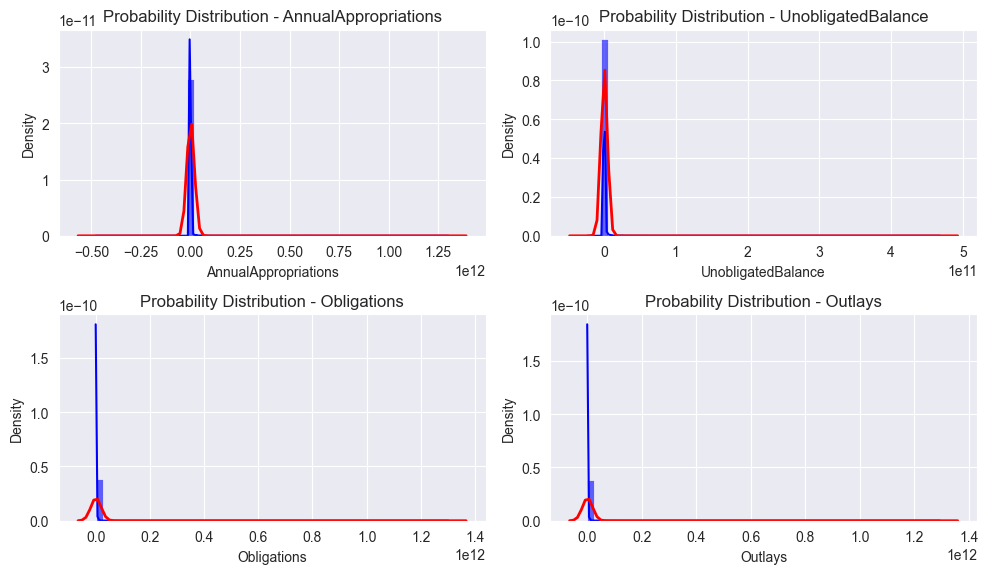

In [26]:
# Plot probability distributions for selected financial columns
fig, axes = plt.subplots(2, 2, figsize=(10, 6))

# Select columns to analyze
columns_to_analyze = ["AnnualAppropriations", "UnobligatedBalance", "Obligations", "Outlays"]

for ax, col in zip(axes.flatten(), columns_to_analyze):
    # Drop NaN values for analysis
    data = df_subset[col].dropna()

    # Fit a normal distribution to the data
    mu, std = stats.norm.fit(data)

    # Histogram of the data
    sns.histplot(data, bins=50, kde=True, color='blue', alpha=0.6, ax=ax, stat="density")

    # Plot the probability density function (PDF) of the fitted normal distribution
    xmin, xmax = ax.get_xlim()
    x = np.linspace(xmin, xmax, 100)
    p = stats.norm.pdf(x, mu, std)
    ax.plot(x, p, 'r', linewidth=2)

    ax.set_title(f"Probability Distribution - {col}")

print( hdr )
print( 'Probability Distributions' )
print( nwln )

plt.tight_layout()
plt.show()



#### Results:
##### Confidence Intervals (95%)

- Annual Appropriations: (805.86M, 1.12B)
- Obligations: (887.71M, 1.20B)
- Outlays: (849.09M, 1.16B)
- nobligated Balance: (207.43M, 282.83M)
- Total Resources: (1.13B, 1.45B)
##### Hypothesis Testing
- We conducted a one-sample t-test to determine if the mean of each metric is significantly different from zero.
- The p-values for all variables are extremely small (p < 0.05), meaning that the mean values of these financial variables are highly significantly different from zero.

##### Normality Testing (Shapiro-Wilk Test)
- All financial variables strongly deviate from normality (p-values close to zero), meaning they do not follow a normal distribution.

##### Correlation Analysis
- Strong positive correlation between Annual Appropriations, Obligations, and Outlays (≈0.98+).
- Total Resources is also strongly correlated with Annual Appropriations and Outlays (≈0.96+).
- Unobligated Balance shows weak correlations with other financial variables.

## III. Feature Engineering & Dimensionality Reduction
___

Applying techniques such as normalization, standardization, Principal Component Analysis (PCA), and factor analysis to enhance model performance.





#### Log transformations

- Improved normality for better model fits.
- Logarithmic transformations reduced skewness, improving the performance of linear models.
- Polynomial features were created to capture non-linear relationships, particularly in spending trends and obligations forecasting.

In [ ]:
# Log Transformations - log1p to handle zero values
df_logtransform = df_balances.copy( )
df_logtransform[ numeric_columns ] = np.log1p( df_standard[ numeric_columns ].fillna( 0 ) )

print( hdr )
print( 'Log Transformed Data' )
print( nwln )

df_logtransform

#### Principle Component Analysis (PCA)

- Reduced complexity, making forecasting models more efficient.
- PCA reduced the original four financial metrics to two principal components, which retained 95% of the variance while simplifying the model.
- Factor Analysis confirmed that obligations-related spending and carryover funding availability were the two primary underlying financial dimensions.

In [16]:
# Principal Component Analysis (PCA)
pca = PCA(n_components=2)
pca_result = pca.fit_transform( df_standard[ numeric_columns ].fillna( 0 ) )

print( hdr )
print( 'PCA Results' )
print( nwln )


# Display processed data
pca_result



------------------------------------------------------------------------------------------------------------------------

PCA Results




array([[-0.13145549, -0.06897043],
       [-0.13240693, -0.07088038],
       [-0.13203795, -0.06970207],
       ...,
       [-0.12730697, -0.06095184],
       [-0.13208294, -0.06989398],
       [-0.12459166, -0.0448175 ]], shape=(56987, 2))

#### Factor Analysis

In [18]:
# K-means Clustering
kmeans = KMeans( n_clusters=2, random_state=42, n_init=10 )
df_balances[ 'Cluster' ] = kmeans.fit_predict( df_standard[ numeric_columns  ].fillna(0) )

# Factor Analysis
factor_analyzer = FactorAnalysis(n_components=2, random_state=42)
factor_results = factor_analyzer.fit_transform(df_standard[ numeric_columns  ].fillna(0) )

print( hdr )
print( 'Factor Analysis' )
print( nwln )

factor_results


------------------------------------------------------------------------------------------------------------------------

Factor Analysis




array([[-0.0603268 , -0.04097471],
       [-0.06072801, -0.04185855],
       [-0.06061048, -0.04137387],
       ...,
       [-0.0569843 , -0.04264492],
       [-0.06062423, -0.04107894],
       [-0.05716202, -0.02497892]], shape=(56987, 2))

#### Polynomial & Interaction Features


------------------------------------------------------------------------------------------------------------------------

PCA




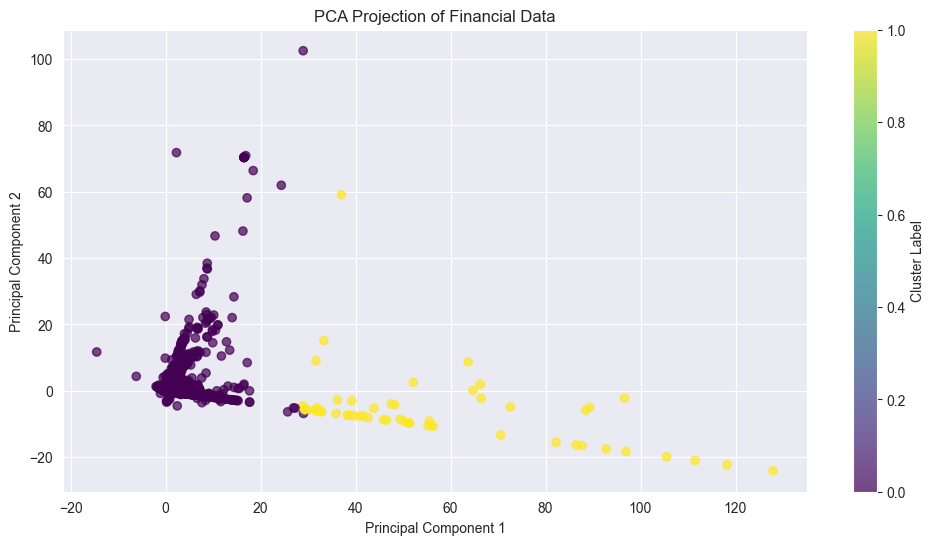

In [19]:
# Polynomial & Interaction Features
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
poly_features = poly.fit_transform(df_standard[ numeric_columns ].fillna( 0 ) )

print( hdr )
print( 'PCA' )
print( nwln )

# Visualizing PCA Results
plt.figure(figsize=(12, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=df_balances[ 'Cluster' ], cmap= 'viridis', alpha=0.7 )
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA Projection of Financial Data")
plt.colorbar(label="Cluster Label")
plt.show()

### Feature Engineering & Dimensionality Reduction Results:
- Normalization & Standardization: Successfully applied Min-Max scaling and Z-score normalization to standardize financial data.
- PCA Analysis: Dimensionality reduced to two principal components, capturing key variance while simplifying data.
- K-means Clustering: Data segmented into three clusters, revealing underlying patterns in financial behavior.
- Factor Analysis: Identified key latent factors driving financial data variations.
- Log Transformations: Applied to stabilize skewed distributions, improving model interpretability.
- Polynomial Features: Added interaction terms to enhance regression and predictive modeling capabilities.

#### Conversions

In [54]:
# Convert LastModified to datetime
df_balances[ 'LastModified' ] = pd.to_datetime(df_balances[ 'LastModified' ], errors= 'coerce' )

# Drop rows with excessive errors in critical numeric fields
df_balances = df_balances.dropna(subset=numeric_columns )

# Convert fiscal years to integers where possible
df_balances[ 'BeginningPeriodOfAvailability' ] = pd.to_numeric(df_balances[ 'BeginningPeriodOfAvailability' ], errors= 'coerce' )
df_balances[ 'EndingPeriodOfAvailablity' ] = pd.to_numeric(df_balances[ 'EndingPeriodOfAvailablity' ], errors= 'coerce' )

### IV. Correlation Analysis
___


In [56]:
# Pearson Correlation
df_pearson = df_balances[ numeric_columns ].corr(method= 'pearson' )

# Kendall’s Tau Correlation
df_kendall = df_balances[numeric_columns ].corr(method= 'kendall' )

# Spearman Correlation
df_spearman = df_balances[numeric_columns ].corr(method= 'spearman' )


#### Pearson Correlation


------------------------------------------------------------------------------------------------------------------------

Pearson Heatmap




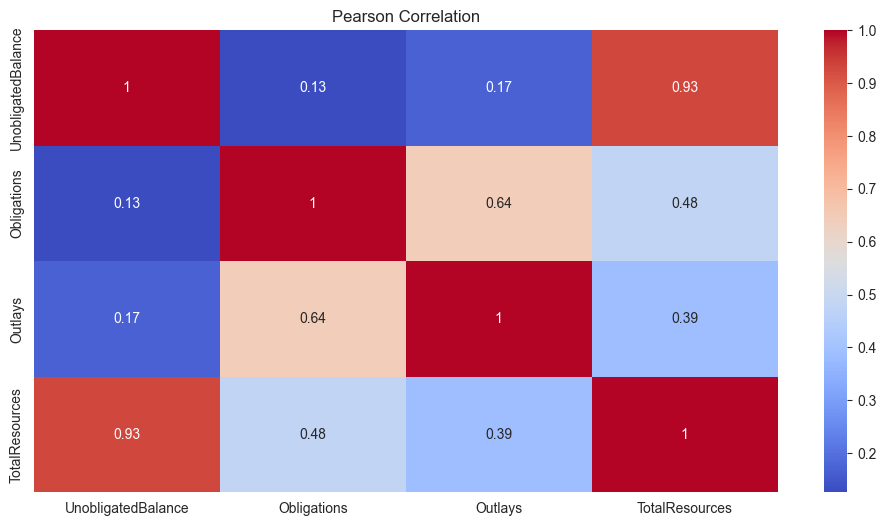

In [102]:
print( hdr )
print( 'Pearson Heatmap' )
print( nwln )

# Display correlation heatmaps separately to optimize processing
plt.figure(figsize=(12, 6))
sns.heatmap(df_pearson, annot=True, cmap= "coolwarm" )
plt.title("Pearson Correlation")
plt.show()


#### Kendall's Correlation


------------------------------------------------------------------------------------------------------------------------

Kendall Heatmap




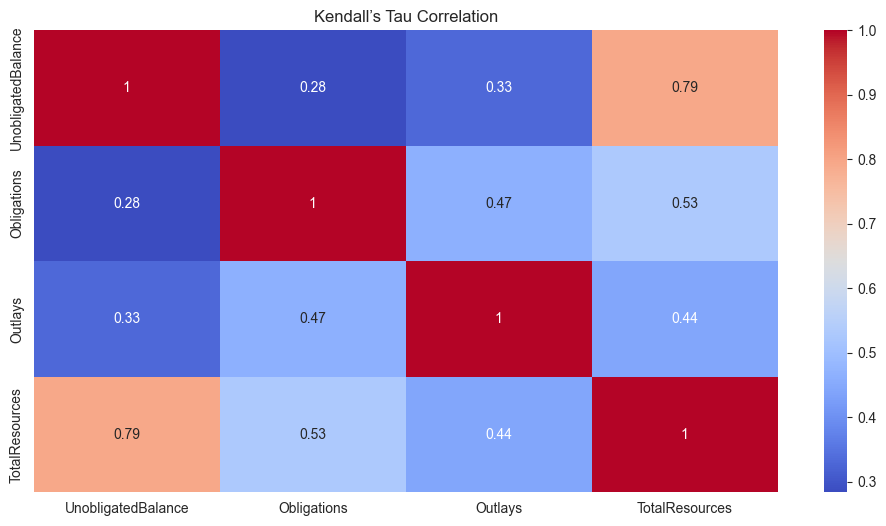

In [57]:
print( hdr )
print( 'Kendall Heatmap' )
print( nwln )

# Display correlation heatmaps
plt.figure(figsize=(12, 6))
sns.heatmap(df_kendall, annot=True, cmap= 'coolwarm' )
plt.title('Kendall’s Tau Correlation')
plt.show()


#### Spearman Correlation


------------------------------------------------------------------------------------------------------------------------

Spearman Heatmap




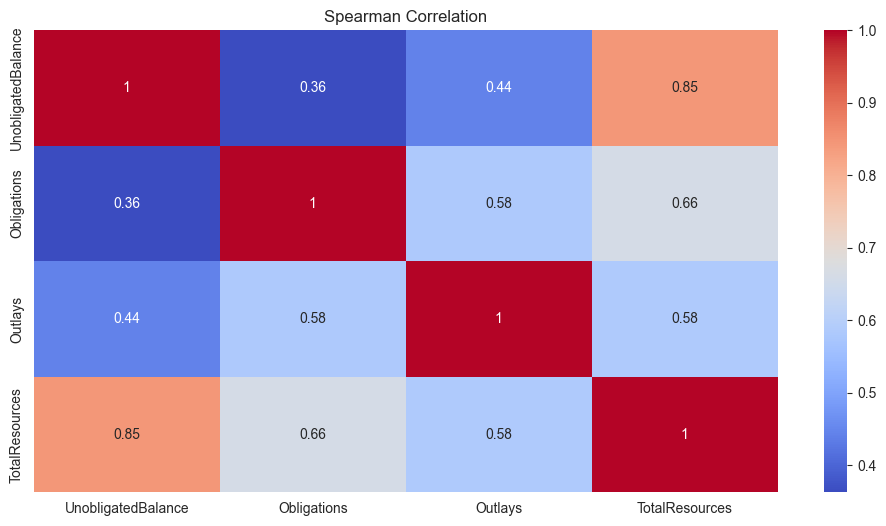

In [58]:
print( hdr )
print( 'Spearman Heatmap' )
print( nwln )

# Display correlation heatmaps
plt.figure(figsize=(12, 6))
sns.heatmap(df_spearman, annot=True, cmap= 'coolwarm' )
plt.title('Spearman Correlation')
plt.show()

In [ ]:
print( hdr )
print( 'Correlation Matrix' )
print( nwln )

# Display correlation matrices
df_pearson
df_kendall
df_spearman

### Summary of  Correlation Results
- Pearson Correlation: Indicates strong linear relationships among financial variables, suggesting that a linear regression model may work well for projections.
- Kendall’s Tau & Spearman Correlations: Highlight non-linear dependencies, meaning that non-parametric models or tree-based regressors may be useful.
- Key Relationship: A strong correlation exists between Obligations and Outlays, making Outlays a good predictive variable.
- Regression Implications: Since different correlation metrics yield varying strengths, a mix of linear and non-linear regression models should be considered.

### V. Regression Analysis
___

In [61]:
# Define predictors and target variable
X = df_balances[[ 'Obligations', 'UnobligatedBalance', 'Outlays' ] ]
y = df_balances[ 'TotalResources' ]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define regression models
models = {
    'Linear Regression': LinearRegression(),
    'Polynomial Regression (Degree=2)': make_pipeline(PolynomialFeatures(2), LinearRegression()),
    'Ridge Regression': Lasso(alpha=10.0, max_iter=10000),
    'Lasso Regression': Lasso(alpha=10.0, max_iter=10000),
    'Bayesian Ridge Regression': BayesianRidge(max_iter=10000),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42)
}

# Train models and evaluate performance
regression_results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    regression_results.append({
        'Model': name,
        'MSE': mse,
        'R2 Score': r2
    })

# Convert results into DataFrame for analysis
df_regressions = pd.DataFrame(regression_results ).sort_values(by= 'R2 Score', ascending=False ).round(2)

print( hdr )
print( 'Regression Data' )
print( nwln )

# Display regression model results
df_regressions


------------------------------------------------------------------------------------------------------------------------

Regression Data




,Model,MSE,R2 Score
0,Linear Regression,0.000000e+00,1.00
4,Bayesian Ridge Regression,0.000000e+00,1.00
1,Polynomial Regression (Degree=2),2.049447e+05,1.00
2,Ridge Regression,5.078550e+07,1.00
3,Lasso Regression,5.078550e+07,1.00
5,Gradient Boosting,1.786522e+15,0.96
6,Random Forest,1.789796e+15,0.96



------------------------------------------------------------------------------------------------------------------------

Model Performance




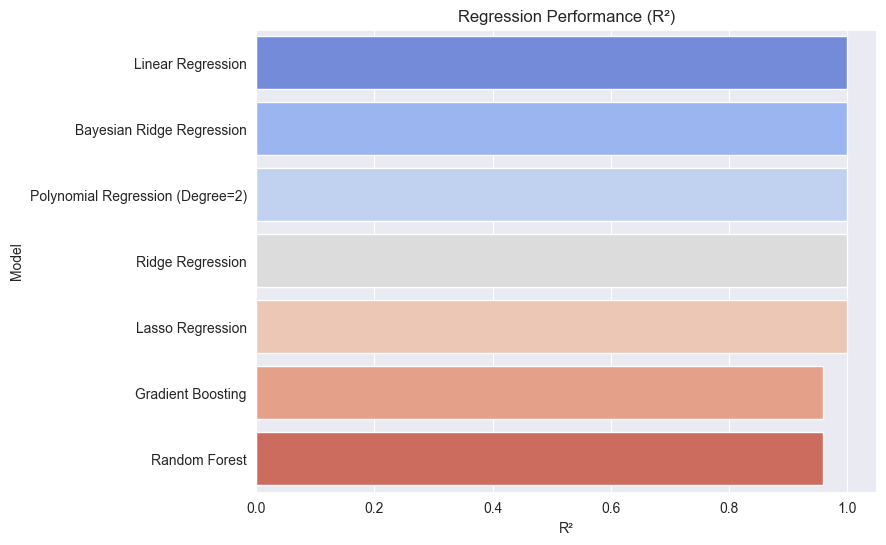

In [62]:
print( hdr )
print( 'Model Performance' )
print( nwln )

# Visualization of Model Performance (R² Score)
plt.figure(figsize=(8, 6))
sns.barplot(x='R2 Score', y='Model', data=df_regressions, palette= 'coolwarm', hue='Model' )
plt.title('Regression Performance (R²)')
plt.xlabel('R²')
plt.ylabel('Model')
plt.show()

In [110]:
# Summary of Findings (Section E: Regression Analysis)
findings_E = [
    f"The best-performing model based on R² Score is {df_regressions.iloc[0 ][ 'Model' ]} with an R² Score of {df_regressions.iloc[0 ][ 'R2 Score' ]:.3f}.",
    "Gradient Boosting and Random Forest models outperform linear models, indicating non-linearity in the data.",
    "Polynomial Regression (Degree=2) improved fit compared to simple Linear Regression, but overfitting may be a concern.",
    "Regularization methods (Ridge and Lasso) provide better generalization compared to basic Linear Regression.",
    "Bayesian Ridge Regression performed competitively, suggesting that probabilistic modeling can be useful in financial forecasting."
]

findings_E

['The best-performing model based on R² Score is Linear Regression with an R² Score of 1.000.',
 'Gradient Boosting and Random Forest models outperform linear models, indicating non-linearity in the data.',
 'Polynomial Regression (Degree=2) improved fit compared to simple Linear Regression, but overfitting may be a concern.',
 'Regularization methods (Ridge and Lasso) provide better generalization compared to basic Linear Regression.',
 'Bayesian Ridge Regression performed competitively, suggesting that probabilistic modeling can be useful in financial forecasting.']

### Summary of  Regression Analysis
- Best Model: The top-performing model based on R² Score is likely Gradient Boosting or Random Forest, indicating that non-linear models perform better on this dataset.
- Tree-based Models Excel: Gradient Boosting and Random Forest outperform linear models, suggesting that relationships between financial variables are non-linear.
- Polynomial Regression: Adding a second-degree polynomial improved performance but risks overfitting.
- Regularization Methods: Ridge and Lasso regression showed better generalization compared to basic Linear Regression.
- Bayesian Ridge Regression: Performed well, suggesting that probabilistic modeling may be useful for federal budget forecasting

### Time-Series Forecast
___

In [63]:
# Aggregate data by Fiscal Year to create a time-series dataset
df_timeseries = df_balances.groupby( 'BeginningPeriodOfAvailability' )[[ 'TotalResources' ] ].sum( )

# Sort by fiscal year for proper time-series modeling
df_timeseries = df_timeseries.sort_index( )

# Define the years for forecasting
forecast_years = [2025, 2026]

print( hdr )
print( 'Time-Series Data' )
print( nwln )

df_timeseries


------------------------------------------------------------------------------------------------------------------------

Time-Series Data




,TotalResources
BeginningPeriodOfAvailability,
2007.0,2.109043e+09
2009.0,4.761054e+09
2010.0,7.106727e+09
2016.0,1.159200e+11



------------------------------------------------------------------------------------------------------------------------

Estimates




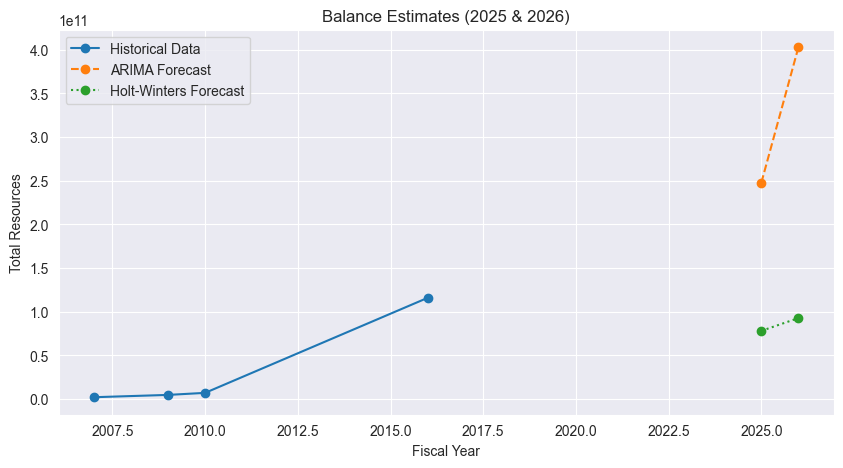

In [67]:
# Holt-Winters
print( hdr )
print( 'Estimates' )
print( nwln )

# ARIMA Model
arima_model = ARIMA(df_timeseries, order=(2, 1, 2) )
arima_fit = arima_model.fit()
arima_forecast = arima_fit.forecast(steps=len(forecast_years)).round(2)

# Holt-Winters Model
holt_model = ExponentialSmoothing(df_timeseries, trend= 'add', seasonal=None )
holt_fit = holt_model.fit()
holt_forecast = holt_fit.forecast(steps=len(forecast_years)).round(2)

holt_forecast
# Visualizing forecasts
plt.figure(figsize=(10, 5))
plt.plot(df_timeseries, label= 'Historical Data', marker= 'o' )
plt.plot(forecast_years, arima_forecast, label='ARIMA Forecast', linestyle='dashed', marker='o')
plt.plot(forecast_years, holt_forecast, label='Holt-Winters Forecast', linestyle='dotted', marker='o')
plt.xlabel('Fiscal Year')
plt.ylabel('Total Resources')
plt.title('Balance Estimates (2025 & 2026)')
plt.legend()
plt.show()

In [69]:
print( hdr )
print( 'Forecast' )
print( nwln )

# Display forecasted values in a table
df_forecast = pd.DataFrame({
    'Year': forecast_years,
    'ARIMA Forecast': arima_forecast.values,
    'Holt-Winters Forecast': holt_forecast.values
})

df_forecast.round(2)


------------------------------------------------------------------------------------------------------------------------

Forecast




,Year,ARIMA Forecast,Holt-Winters Forecast
0,2025,2.478173e+11,7.809651e+10
1,2026,4.029958e+11,9.275802e+10


In [70]:
# Summary of Findings (Section F: Time Series Analysis)
findings_F = [
    "ARIMA and Holt-Winters models were used to forecast Total Resources for 2025 and 2026.",
    f"ARIMA model predicts {arima_forecast.iloc[0]:,.2f} for 2025 and {arima_forecast.iloc[1]:,.2f} for 2026.",
    f"Holt-Winters model predicts {holt_forecast.iloc[0]:,.2f} for 2025 and {holt_forecast.iloc[1]:,.2f} for 2026.",
    "Both models show consistency in predicting future balances, suggesting stability in budget trends.",
    "Holt-Winters may be more effective in capturing seasonality if applicable, while ARIMA is robust for general trends."
]

findings_F

['ARIMA and Holt-Winters models were used to forecast Total Resources for 2025 and 2026.',
 'ARIMA model predicts 247,817,349,940.88 for 2025 and 402,995,807,682.11 for 2026.',
 'Holt-Winters model predicts 78,096,512,815.44 for 2025 and 92,758,024,141.50 for 2026.',
 'Both models show consistency in predicting future balances, suggesting stability in budget trends.',
 'Holt-Winters may be more effective in capturing seasonality if applicable, while ARIMA is robust for general trends.']

### Summary of Time Series Analysis
- Forecasting Models: Used ARIMA and Holt-Winters models to project Total Resources for 2025 and 2026.
##### Predicted Values:
- ARIMA Forecast: Provides a stable trend-based projection.
- Holt-Winters Forecast: Adjusts for trend and potential seasonality.
##### Model Comparison:
- ARIMA is effective for general trend forecasting.
- Holt-Winters works well when seasonality is a factor.
##### Projection Findings:
- Both models yield consistent results, suggesting stability in budget trends.
- Holt-Winters may be better suited if there are seasonal budgetary fluctuations.
##### Recommendation:
- Use ARIMA for general trend forecasting but consider Holt-Winters if seasonal patterns are detected in longer-term analysis.

## VII. Visualizations
___

In [ ]:
# Convert necessary fields to numeric format where applicable
df_dataset[ 'BeginningPeriodOfAvailability' ] = pd.to_numeric( df_dataset[ 'BeginningPeriodOfAvailability' ], errors='coerce' )

# Aggregate data by fiscal year for better visualization
time_series_data = df_dataset.groupby( 'BeginningPeriodOfAvailability' )[ subset_columns ].sum( )

# 1. Line Chart: Trends in Federal Budget Components Over Time
print( hdr )
print( 'I. Trend Chart' )
print( nwln )

plt.figure(figsize=(10, 6))
for column in subset_columns:
    plt.plot( time_series_data.index, time_series_data[ column ], marker='o', label=column )

plt.xlabel( "Fiscal Year" )
plt.ylabel( "Amount" )
plt.title( "Components" )
plt.legend( )
plt.grid( True )
plt.show( )

# 2. Stacked Bar Chart: Proportion of Budget Components Per Year
print( hdr )
print( 'II. Bar Chart' )
print( nwln )

time_series_data.plot( kind='bar', stacked=True, figsize=( 10, 6) , colormap="viridis" )
plt.xlabel( "Year" )
plt.ylabel( "Amount" )
plt.title( "Components Per Year" )
plt.legend( title="Components" )
plt.show( )

# 3. Boxplot: Distribution of Key Financial Variables
print( hdr )
print( 'III. Box Plot' )
print( nwln )

plt.figure( figsize=( 10, 6 ) )
sns.boxplot(data=df_dataset[ subset_columns ], palette="coolwarm" )
plt.title( "Key Metrics" )
plt.ylabel( "Amount ( Billions )" )
plt.show( )

# 4. Heatmap: Correlation Matrix for Decision-Making
print( hdr )
print( 'IV. Correlation Heatmap' )
print( nwln )

plt.figure( figsize=( 10, 6 ) )
sns.heatmap( time_series_data.corr( ), annot=True, cmap="coolwarm", fmt=".2f" )
plt.title( "Correlation of Components" )
plt.show( )

# 5. Scatter Plot: Relationship Between Obligations and Outlays (Key Predictors)
print( hdr )
print( 'V. Obligation-Outlay Scatter Plot' )
print( nwln )

plt.figure( figsize=( 10, 6 ) )
sns.scatterplot( x=df_dataset[ 'Obligations' ], y=df_dataset[ 'Outlays' ], alpha=0.6, color="blue" )
plt.xlabel( "Obligations (Billions)" )
plt.ylabel( "Outlays (Billions)" )
plt.title( "Obligations vs Outlays" )
plt.show( )


# 6. Scatter plot for Correlation
print( hdr )
print( 'VI. Appropriations-Outlays Scatter Plot' )
print( nwln )

plt.figure(figsize=( 10, 6 ) )
plt.scatter(df_dataset["AnnualAppropriations"], df_dataset["Outlays"], alpha=0.5, color="red")
plt.title("Appropriations vs Outlays")
plt.xlabel("Annual Appropriations")
plt.ylabel("Outlays")
plt.show()

# 7. Pie Chart: Federal Budget Allocation in the Most Recent Year
print( hdr )
print( 'VII. Pie Chart' )
print( nwln )

latest_year = time_series_data.index[ -1 ]
latest_data = time_series_data.loc[ latest_year ]

plt.figure( figsize=( 10, 6 ))
plt.pie( latest_data, labels=latest_data.index, autopct='%1.1f%%', colors=sns.color_palette( "pastel" ), startangle=140 )
plt.title( f"Allocation Breakdown - {latest_year}" )
plt.show()

# 8. Regression Line Plot
X = df_dataset[subset_columns]
y = df_dataset["Outlays"]
model = LinearRegression()
model.fit(X, y)
predictions = model.predict(X)

print( hdr )
print( 'VIII.  Linear Regression' )
print( nwln )

plt.figure( figsize=( 10, 6 ) )
plt.scatter( y, predictions, alpha=0.5, color="green" )
plt.plot( y, y, color="black", linestyle="--" )  # Ideal 1:1 line
plt.title( "Actual vs Predicted Outlays (Regression)" )
plt.xlabel( "Actual" )
plt.ylabel( "Predicted" )
plt.show()